In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../scripts/')

Import Packages

In [44]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from pathlib import Path
from data_cleaner import DataCleaner
%matplotlib inline

Initalize configs

In [27]:
pwd = Path().cwd()
root_dir = pwd.parent
data_dir = root_dir / "data"
file_path = data_dir / "corrected_data.csv"

# sets global styling for graphs
plt.style.use('seaborn')

# to convert the scientific notation to decimal format
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# reset the decimal format back to scientific notation
# pd.reset_option('display.float_format')

In [28]:
data = pd.read_csv(file_path, na_values=["undefined"], parse_dates=["Start", "End"])

In [29]:
data_modified = data.copy()

In [30]:
data_modified.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (s)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms)', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',
   

In [31]:
user_agg = data_modified.groupby(["MSISDN/Number"], as_index=False).agg({'TCP DL Retrans. Vol (Bytes)':'sum', "TCP UL Retrans. Vol (Bytes)": "sum", "Avg RTT DL (ms)": "sum", "Avg RTT UL (ms)": "sum",  "Avg Bearer TP DL (kbps)": "sum", "Avg Bearer TP UL (kbps)": "sum", 'Handset Type': 'first' })

In [32]:
user_agg.reset_index(drop=True, inplace=True)

In [33]:
user_agg.head()

,MSISDN/Number,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Handset Type
0,33601001722.00,0.00,0.00,46.00,0.00,37.00,39.00,Huawei P20 Lite Huawei Nova 3E
1,33601001754.00,0.00,0.00,30.00,1.00,48.00,51.00,Apple iPhone 7 (A1778)
2,33601002511.00,0.00,0.00,0.00,0.00,48.00,49.00,None
3,33601007832.00,1066.00,0.00,69.00,15.00,204.00,44.00,Apple iPhone 5S (A1457)
4,33601008617.00,9349630.00,21202.00,114.00,5.00,40395.00,16449.00,Apple iPhone Se (A1723)


In [34]:
user_agg["MSISDN/Number"] = user_agg["MSISDN/Number"].astype(str)

In [35]:
user_agg.dtypes

MSISDN/Number                   object
TCP DL Retrans. Vol (Bytes)    float64
TCP UL Retrans. Vol (Bytes)    float64
Avg RTT DL (ms)                float64
Avg RTT UL (ms)                float64
Avg Bearer TP DL (kbps)        float64
Avg Bearer TP UL (kbps)        float64
Handset Type                    object
dtype: object

In [36]:
transmission_per_user = pd.DataFrame()

In [37]:
transmission_per_user["MSISDN/Number"] = user_agg["MSISDN/Number"]

In [38]:
transmission_per_user["Average TCP Retransmission"] = user_agg["TCP DL Retrans. Vol (Bytes)"] + user_agg["TCP UL Retrans. Vol (Bytes)"]

In [39]:
transmission_per_user["Average RTT"] = user_agg["Avg RTT DL (ms)"] + user_agg["Avg RTT UL (ms)"]

In [40]:
transmission_per_user["Average throughput"] = user_agg["Avg Bearer TP DL (kbps)"] + user_agg["Avg Bearer TP UL (kbps)"]

In [41]:
transmission_per_user["Handset Type"] = user_agg["Handset Type"]

In [42]:
transmission_per_user.head()

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
0,33601001722.0,0.00,46.00,76.00,Huawei P20 Lite Huawei Nova 3E
1,33601001754.0,0.00,31.00,99.00,Apple iPhone 7 (A1778)
2,33601002511.0,0.00,0.00,97.00,None
3,33601007832.0,1066.00,84.00,248.00,Apple iPhone 5S (A1457)
4,33601008617.0,9370832.00,119.00,56844.00,Apple iPhone Se (A1723)


In [45]:
cleaner = DataCleaner()

In [46]:
cleaner.missing_percentage(transmission_per_user)

,column_name,percent_missing
0,MSISDN/Number,0.00
1,Average TCP Retransmission,0.00
2,Average RTT,0.00
3,Average throughput,0.00
4,Handset Type,6.24


In [48]:
cleaner.remove_outliers(transmission_per_user)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
0,33601001722.0,0.00,46.00,76.00,Huawei P20 Lite Huawei Nova 3E
1,33601001754.0,0.00,31.00,99.00,Apple iPhone 7 (A1778)
2,33601002511.0,0.00,0.00,97.00,None
3,33601007832.0,1066.00,84.00,248.00,Apple iPhone 5S (A1457)
4,33601008617.0,820108.75,119.00,56844.00,Apple iPhone Se (A1723)
...,...,...,...,...,...
106851,33789996170.0,218045.00,52.00,10365.00,Huawei Honor 9 Lite
106852,33789997247.0,0.00,40.00,116.00,Apple iPhone 8 Plus (A1897)
106853,3197020876596.0,0.00,0.00,1.00,Quectel Wireless. Quectel Ec25-E
106854,337000037000919.0,0.00,0.00,33.00,Huawei B525S-23A


In [53]:
transmission_per_user.dropna(inplace=True)
transmission_per_user.reset_index(inplace=True, drop=True)

In [54]:
transmission_per_user.nlargest(columns=["Average TCP Retransmission"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
62815,33667725464.0,8354209105.00,703.00,379713.00,Huawei B528S-23A
31962,33659084281.0,7941860302.00,396.00,210259.00,Huawei B528S-23A
39756,33660977522.0,7374139060.00,417.00,216852.00,Huawei B528S-23A
88867,33761284050.0,6043978448.00,351.00,144570.00,Huawei B528S-23A
92162,33762644658.0,5879989037.00,2860.00,549661.00,Huawei B528S-23A
24078,33650658056.0,5593366107.00,1543.00,259548.00,Huawei B528S-23A
48513,33663180885.0,5566928580.00,583.00,127603.00,Huawei B528S-23A
93726,33763572381.0,5179458974.00,479.00,120288.00,Huawei B528S-23A
66610,33669054076.0,5174214964.00,321.00,142042.00,Huawei B528S-23A
29939,33658638625.0,5165856986.00,171.00,105875.00,Huawei B528S-23A


In [55]:
transmission_per_user.nsmallest(columns=["Average TCP Retransmission"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
0,33601001722.0,0.00,46.00,76.00,Huawei P20 Lite Huawei Nova 3E
1,33601001754.0,0.00,31.00,99.00,Apple iPhone 7 (A1778)
9,33601022743.0,0.00,53.00,69.00,Apple iPhone 6 (A1586)
10,33601024291.0,0.00,0.00,15.00,Samsung Sm-G390F
11,33601025738.0,0.00,0.00,98.00,Samsung Galaxy S7 (Sm-G930X)
13,33601027208.0,0.00,20.00,104.00,Apple iPhone 8 (A1905)
15,33601032846.0,0.00,49.00,75.00,Apple iPhone 5S (A1457)
16,33601032987.0,0.00,18.00,149.00,Samsung Galaxy S6 (Sm-G920X)
20,33601036379.0,0.00,0.00,128.00,Samsung Galaxy A5 Sm-A520F
21,33601037966.0,0.00,40.00,68.00,Samsung Galaxy S7 Edge (Sm-G935X)


In [56]:
transmission_per_user.value_counts(subset=["Average TCP Retransmission"])[:10]

Average TCP Retransmission
0.00                          51590
1294.00                         461
1330.00                         403
2660.00                         208
1318.00                         182
38.00                           129
92.00                           119
3990.00                         118
5320.00                          97
2636.00                          87
dtype: int64

In [57]:
transmission_per_user.nlargest(columns=["Average RTT"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
45070,33662317023.0,0.00,96924.00,3.00,Apple iPhone 8 (A1905)
39371,33660874265.0,0.00,64670.00,194.00,Apple iPhone 6 (A1586)
75321,33683692867.0,92.00,54848.00,21.00,Lg Lg-D315
80411,33698551167.0,15639.00,46021.00,303.00,Huawei B528S-23A
90483,33761813523.0,76285.00,37084.00,21200.00,Huawei B528S-23A
65890,33668791629.0,0.00,36304.00,108.00,Huawei B528S-23A
88080,33760941100.0,540582.00,27278.00,5148.00,Samsung Galaxy S7 Edge (Sm-G935X)
1599,33606788933.0,13300.00,26300.00,144.00,Samsung Galaxy S9 Plus (Sm-G965F)
69733,33671816754.0,5320.00,25715.00,71.00,Samsung Galaxy S6 Edge (Sm-G925X)
97819,33781865588.0,199904.00,25388.00,1608.00,Apple iPhone 6S (A1688)


In [58]:
transmission_per_user.nsmallest(columns=["Average RTT"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
10,33601024291.0,0.00,0.00,15.00,Samsung Sm-G390F
11,33601025738.0,0.00,0.00,98.00,Samsung Galaxy S7 (Sm-G930X)
20,33601036379.0,0.00,0.00,128.00,Samsung Galaxy A5 Sm-A520F
29,33601055238.0,0.00,0.00,134.00,Samsung Galaxy Note 8 (Sm-N950F)
32,33601056091.0,0.00,0.00,97.00,Samsung Galaxy S8 (Sm-G950F)
40,33601073097.0,0.00,0.00,194.00,Samsung Galaxy J3 (Sm-J330)
50,33601100578.0,0.00,0.00,96.00,Samsung Galaxy S8 (Sm-G950F)
65,33601152653.0,0.00,0.00,74.00,Samsung Galaxy A5 Sm-A520F
70,33601155426.0,0.00,0.00,113.00,Samsung Galaxy J7 (Sm-J730)
74,33601160415.0,0.00,0.00,249.00,Samsung Galaxy S8 (Sm-G950F)


In [59]:
transmission_per_user.value_counts(subset=["Average RTT"])[:10]

Average RTT
0.00           15680
29.00           2642
39.00           2120
38.00           1443
30.00           1412
40.00           1381
28.00           1304
49.00           1195
31.00           1051
41.00           1045
dtype: int64

In [60]:
transmission_per_user.nlargest(columns=["Average throughput"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
91585,33762333464.0,4793860.00,400.00,902222.00,Samsung Galaxy A8 (2018)
65673,33668708263.0,142987086.00,500.00,840424.00,Huawei B528S-23A
33986,33659546392.0,33968213.00,588.00,798342.00,Huawei B528S-23A
68706,33669946573.0,62717561.00,370.00,690815.00,Huawei B528S-23A
64844,33668425947.0,787659604.00,382.00,676858.00,Huawei B528S-23A
12324,33625700673.0,6293712.00,454.00,564179.00,Samsung Galaxy S9 Sm-G960F Ds
27416,33658075438.0,28784094.00,567.00,550352.00,Huawei B528S-23A
92162,33762644658.0,5879989037.00,2860.00,549661.00,Huawei B528S-23A
57084,33665658364.0,11248249.00,188.00,530353.00,Huawei B528S-23A
59205,33666461685.0,12325061.00,543.00,524686.00,Huawei B528S-23A


In [61]:
transmission_per_user.nsmallest(columns=["Average throughput"], n=10)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
796,33603452974.0,0.00,0.00,0.00,Samsung Galaxy S9 Sm-G960F Ds
1125,33604131582.0,0.00,0.00,0.00,Lenovo Moto G (3Rd Gen) Ca12459445
2436,33608752702.0,0.00,0.00,0.00,Samsung Galaxy J3 (Sm-J320X)
2497,33608892887.0,0.00,0.00,0.00,Samsung Galaxy S8 (Sm-G950F)
3038,33609847664.0,0.00,0.00,0.00,Samsung Galaxy S7 Edge (Sm-G935X)
4015,33611523366.0,0.00,0.00,0.00,Samsung Galaxy S7 Edge (Sm-G935X)
6755,33616110252.0,0.00,0.00,0.00,Apple iPhone Xr (A2105)
7052,33616605202.0,0.00,0.00,0.00,Huawei P10
7916,33618191988.0,0.00,0.00,0.00,Samsung Galaxy S7 Edge (Sm-G935X)
8873,33619834498.0,0.00,0.00,0.00,Samsung Galaxy A8 (2018)


In [62]:
transmission_per_user.value_counts(subset=["Average throughput"])[:10]

Average throughput
63.00                 2016
15.00                 1969
97.00                  944
90.00                  938
98.00                  891
96.00                  804
99.00                  792
89.00                  772
93.00                  760
95.00                  745
dtype: int64

In [63]:
transmission_per_user.groupby(by=["Handset Type"], as_index=False).agg({"Average throughput": 'count'}).nlargest(n=10, columns="Average throughput")

,Handset Type,Average throughput
316,Huawei B528S-23A,10615
53,Apple iPhone 6S (A1688),6759
49,Apple iPhone 6 (A1586),6260
59,Apple iPhone 7 (A1778),4699
73,Apple iPhone Se (A1723),3754
66,Apple iPhone 8 (A1905),3543
953,Samsung Galaxy S8 (Sm-G950F),3245
78,Apple iPhone Xr (A2105),3072
886,Samsung Galaxy J5 (Sm-J530),2748
836,Samsung Galaxy A5 Sm-A520F,2708


In [64]:
transmission_per_user.groupby(by=["Handset Type"], as_index=False).agg({"Average TCP Retransmission": 'sum'}).nlargest(n=10, columns="Average TCP Retransmission")

,Handset Type,Average TCP Retransmission
316,Huawei B528S-23A,1056258263639.00
337,Huawei E5180,63324806810.00
341,Huawei E5573,15958548804.00
53,Apple iPhone 6S (A1688),11710184588.00
49,Apple iPhone 6 (A1586),11126291045.00
78,Apple iPhone Xr (A2105),8982743636.00
59,Apple iPhone 7 (A1778),8342464261.00
75,Apple iPhone X (A1901),8003656105.00
953,Samsung Galaxy S8 (Sm-G950F),6622122051.00
342,Huawei E5573B,6546747004.00


In [65]:
transmission_per_user.head()

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type
0,33601001722.0,0.00,46.00,76.00,Huawei P20 Lite Huawei Nova 3E
1,33601001754.0,0.00,31.00,99.00,Apple iPhone 7 (A1778)
2,33601007832.0,1066.00,84.00,248.00,Apple iPhone 5S (A1457)
3,33601008617.0,9370832.00,119.00,56844.00,Apple iPhone Se (A1723)
4,33601010682.0,2760.00,24.00,7908.00,Samsung Galaxy A8 (2018)


In [66]:
scaler = MinMaxScaler()

In [67]:
df_norm = pd.DataFrame(scaler.fit_transform(transmission_per_user.select_dtypes(include=np.number)), columns=transmission_per_user.select_dtypes(include=np.number).columns)

In [68]:
df_norm.head()

,Average TCP Retransmission,Average RTT,Average throughput
0,0.00,0.00,0.00
1,0.00,0.00,0.00
2,0.00,0.00,0.00
3,0.00,0.00,0.06
4,0.00,0.00,0.01


In [71]:
kmeans = KMeans(n_clusters=3)
y_predicted = kmeans.fit_predict(transmission_per_user.select_dtypes(include=np.number))
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [72]:
transmission_per_user["Cluster"] = kmeans.labels_

In [73]:
transmission_per_user.head()

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type,Cluster
0,33601001722.0,0.00,46.00,76.00,Huawei P20 Lite Huawei Nova 3E,0
1,33601001754.0,0.00,31.00,99.00,Apple iPhone 7 (A1778),0
2,33601007832.0,1066.00,84.00,248.00,Apple iPhone 5S (A1457),0
3,33601008617.0,9370832.00,119.00,56844.00,Apple iPhone Se (A1723),0
4,33601010682.0,2760.00,24.00,7908.00,Samsung Galaxy A8 (2018),0


<AxesSubplot:xlabel='Average TCP Retransmission', ylabel='Average throughput'>

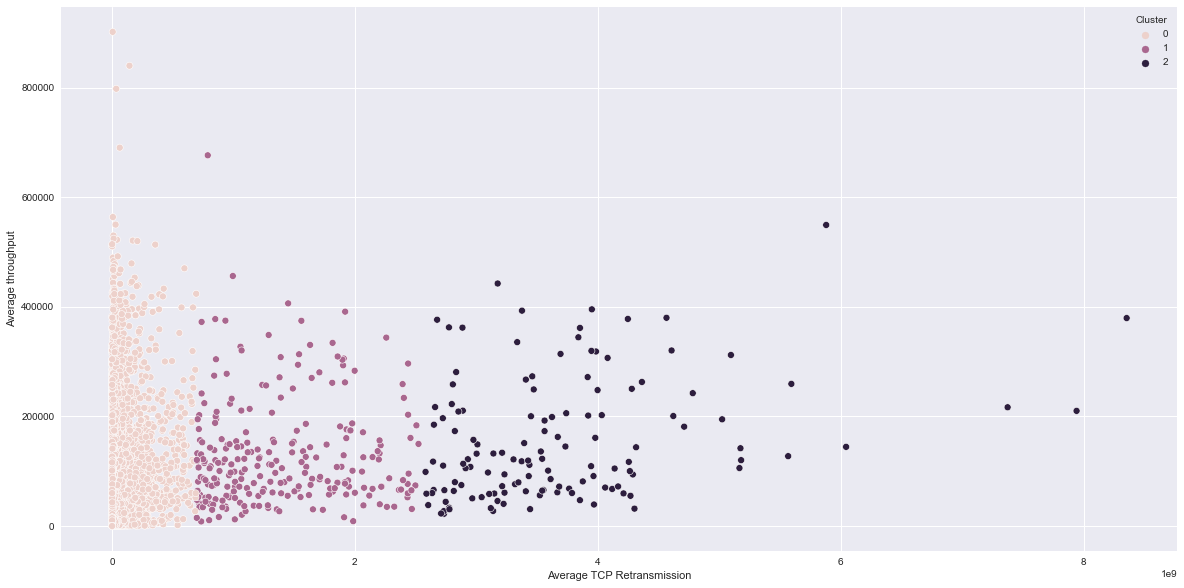

In [74]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x="Average TCP Retransmission", y="Average throughput", hue = 'Cluster',  data=transmission_per_user, ax=ax)

In [75]:
transmission_per_user.loc[transmission_per_user["Cluster"] == 0].sort_values(by=["Average TCP Retransmission","Average RTT"], ascending=False)

,MSISDN/Number,Average TCP Retransmission,Average RTT,Average throughput,Handset Type,Cluster
88696,33761214860.0,692435929.00,1386.00,424082.00,Huawei B528S-23A,0
93531,33763500518.0,687994728.00,440.00,59875.00,Huawei B525S-23A,0
86374,33760170847.0,686784296.00,443.00,52424.00,Huawei B528S-23A,0
88318,33761078763.0,684750134.00,628.00,285423.00,Huawei B528S-23A,0
91220,33762177288.0,684146656.00,304.00,26993.00,Huawei E5573B,0
...,...,...,...,...,...,...
100175,33789914862.0,0.00,0.00,65.00,Samsung Galaxy J6,0
100180,33789960306.0,0.00,0.00,106.00,Samsung Galaxy S8 Plus (Sm-G955F),0
100184,3197020876596.0,0.00,0.00,1.00,Quectel Wireless. Quectel Ec25-E,0
100185,337000037000919.0,0.00,0.00,33.00,Huawei B525S-23A,0
